In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve,confusion_matrix,accuracy_score, auc

from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler

from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPool1D
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

import imblearn
from imblearn.over_sampling import SMOTE

In [12]:
# Read the dataset
df = pd.read_csv('F:creditcard.csv')
#check on the size of the dataframe
df.shape

(284807, 31)

In [13]:
# We separate the feature vector from the classification result
X = df.drop('Class',axis=1).values
y = df['Class'].values

In [14]:
# Feature scaling
X -= X.min(axis=0)
X /= X.max(axis=0)

In [15]:
#Separation of data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (199364, 30)
Number transactions y_train dataset:  (199364,)
Number transactions X_test dataset:  (85443, 30)
Number transactions y_test dataset:  (85443,)


In [16]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

#sm = SMOTE(random_state=2)
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

#print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
#print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

#print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 345
Before OverSampling, counts of label '0': 199019 



In [17]:
#Reshape data for the CNN model
reshape_train_x = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
reshape_test_x = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

reshape_train_x.shape


(199364, 30, 1)

In [18]:
#--------------------------------Build new model using encoded data--------------------------
epochs = 50
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = reshape_train_x[1].shape))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(reshape_train_x, y_train, epochs=epochs,validation_data=(reshape_test_x, y_test), verbose=1)

Train on 199364 samples, validate on 85443 samples
Epoch 1/50
199364/199364 [==============================] - 99s 497us/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 2/50
199364/199364 [==============================] - 96s 482us/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 3/50
199364/199364 [==============================] - 97s 489us/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 4/50
199364/199364 [==============================] - 98s 493us/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 5/50
199364/199364 [==============================] - 99s 495us/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 6/50
199364/199364 [==============================] - 99s 495us/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 7/50
199364/199364 [=================

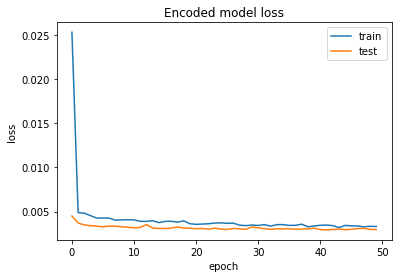

In [19]:
# Summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Encoded model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Overall accuracy of SMOTE - Deep Autoencoder - Convolutional Neural Network model: 0.9994850368081645


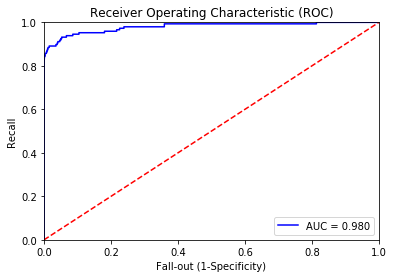

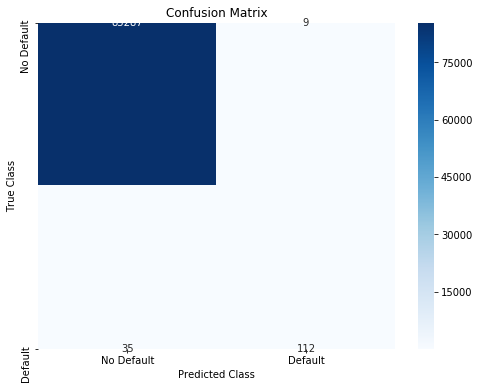

In [20]:
#---------------------------------Predictions and visuallizations-----------------------#Predict on test set
predictions_CNN_prob = model.predict(reshape_test_x)
predictions_CNN_prob = predictions_CNN_prob[:,0]
predictions_CNN_01 = np.where(predictions_CNN_prob > 0.7, 1, 0) #Turn probability to 0-1 binary output
#Print accuracy
acc_CNN = accuracy_score(y_test, predictions_CNN_01)
print('Overall accuracy of SMOTE - Deep Autoencoder - Convolutional Neural Network model:', acc_CNN)
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test,predictions_CNN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
#Print Confusion Matrix
cm = confusion_matrix(y_test, predictions_CNN_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d',cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()